In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from collections import defaultdict
import copy
import seaborn as sns
import pylab as pl
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
from subprocess import check_call
from IPython.display import Image
from sklearn.tree import export_graphviz
from dtreeviz.trees import *

### Install dependencies

In [2]:
# !pip install pandas
# !pip install seaborn
# !pip install sklearn
# !pip install scikit-plot
# !pip install dtreeviz

### Certificate Of Authenticity
<b>Author:</b> Eric Cacciavillani
<br>
<b>Class:</b> DAT-330-01
<br>
<b>Date:</b> January 24, 2019
<br>
<b>Certification of Authenticity: </b>
<br>
 I certify that this is entirely my own work,
 except where I have given fully documented
 references to the work of others.
 I understand the definition and consequences of
 plagiarism and acknowledge that the assessor of this assignment may,
 for the purpose of assessing this assignment reproduce this assignment
 and provide a copy to another member of academic staff and / or communicate
 a copy of this assignment to a plagiarism checking service(which may then
 retain a copy of this assignment on its database for the purpose
 of future plagiarism checking).

### Define functions to use for later use

In [3]:
def cluster_count(clust):
    """
        Returns back dataframe of clustername to the count
    """
    cluster_count_df = pd.DataFrame(columns=['Cluster_Name', "Cluster_Count"])

    for cluster, count in Counter(clust.labels_).items():
        cluster_count_df = cluster_count_df.append({'Cluster_Name': cluster,
                                                    'Cluster_Count': count},
                                                   ignore_index=True)
    return cluster_count_df.sort_values(by=[
        'Cluster_Name']).reset_index(drop=True)


def find_nearest(numbers, target):
    """
        Find the closest fitting number to the target number
    """
    numbers = np.asarray(numbers)
    idx = (np.abs(numbers - target)).argmin()
    return numbers[idx]

# Uses a hash map to decode dataframe data
def encode_decode_df(passed_df, encoder_decoder_map):

    def encode_decode_col(data, decoder):
        return decoder[data]

    df = copy.deepcopy(passed_df)
    for col in df.columns:
        if col in encoder_decoder_map.keys():
            df[col] = np.vectorize(encode_decode_col)(
                df[col], encoder_decoder_map[col])

    return df


def remove_outliers_df(df, removal_dict):
    df = copy.deepcopy(df)

    for feature_name in df.columns:

        # Replacements needed
        if feature_name in removal_dict.keys():
            if removal_dict[feature_name]["High"]:
                df = df[df[feature_name] < removal_dict[feature_name]["High"]]
            elif removal_dict[feature_name]["Low"]:
                df = df[df[feature_name] > removal_dict[feature_name]["Low"]]

    return df.reset_index(drop=True)


def inspect_feature_matrix(matrix,
                           feature_names):
    scaled_mean_matrix = np.mean(scaled, axis=0)
    scaled_std_matrix = np.std(scaled, axis=0)
    scaled_data_dict = dict()
    for index, feature_name in enumerate(feature_names):
        scaled_data_dict[feature_name] = [scaled_mean_matrix[index],
                                          scaled_std_matrix[index]]

    return pd.DataFrame.from_dict(scaled_data_dict,
                                  orient='index',
                                  columns=['Mean', 'Standard Dev'])


def display_rank_graph(feature_names, metric,
                       title="", y_title="", x_title=""):
    plt.figure(figsize=(7, 7))

    # Init color ranking fo plot
    # Ref: http://tinyurl.com/ydgjtmty
    pal = sns.color_palette("GnBu_d", len(metric))
    rank = np.array(metric).argsort().argsort()
    ax = sns.barplot(y=feature_names, x=metric,
                     palette=np.array(pal[::-1])[rank])
    plt.xticks(rotation=0, fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel(x_title, fontsize=20, labelpad=20)
    plt.ylabel(y_title, fontsize=20, labelpad=20)
    plt.title(title, fontsize=15)
    plt.show()
    plt.close()


# General purpose model optimizer
def optimize_model_grid(model,
                        X_train,
                        y_train,
                        param_grid,
                        cv=10):

    # Instantiate the GridSearchCV object: logreg_cv
    model_cv = GridSearchCV(model, param_grid, cv=cv, n_jobs=-1)

    # Fit it to the data
    model_cv.fit(X_train, y_train)

    # Print the tuned parameters and score
    print("Tuned Parameters: {}".format(model_cv.best_params_))
    print("Best score on trained data was {0:4f}".format(model_cv.best_score_))

    model = type(model)(**model_cv.best_params_)

    return model_cv.best_params_


# Not created by me!
# Author: https://github.com/scikit-learn/scikit-learn/issues/7845
def report_to_dict(cr):
    # Parse rows
    tmp = list()
    for row in cr.split("\n"):
        parsed_row = [x for x in row.split("  ") if len(x) > 0]
        if len(parsed_row) > 0:
            tmp.append(parsed_row)

    # Store in dictionary
    measures = tmp[0]

    D_class_data = defaultdict(dict)
    for row in tmp[1:]:
        class_label = row[0]
        for j, m in enumerate(measures):
            D_class_data[class_label][m.strip()] = float(row[j + 1].strip())
    return D_class_data


# I am this lazy yes
def vertical_spacing(spaces=1):
    for _ in range(0, spaces):
        print()

## 1.) Import and analyze dataset

In [4]:
heart_disease = pd.read_csv('datasets/heart_disease_patients.csv')
heart_disease.head()

,id,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
0,1,63,1,1,145,233,1,2,150,0,2.3,3
1,2,67,1,4,160,286,0,2,108,1,1.5,2
2,3,67,1,4,120,229,0,2,129,1,2.6,2
3,4,37,1,3,130,250,0,0,187,0,3.5,3
4,5,41,0,2,130,204,0,2,172,0,1.4,1


### Research attributes
<b>Link</b>:http://archive.ics.uci.edu/ml/datasets/Heart+Disease
<b>age</b>: <p>&emsp; age in years</p>
***
<b>sex</b>: <p>&emsp; 1 = male; 0 = female</p>
***
<b>cp</b>: <p>&emsp; chest pain type
    (1 = typical angina; 2 = atypical angina;
    3 = non-anginal pain; 4 = asymptomatic)</p>
***
<b>trestbps</b>: <p>&emsp; resting blood pressure:
    (in mm Hg on admission to the hospital)</p>
***
<b>chol</b>: <p>&emsp; Cholesterol: serum cholestoral in mg/dl</p>
***
<b>fbs</b>: <p>&emsp; fasting blood sugar > 1
    20 mg/dl (1 = true; 0 = false)</p>
***
<b>restecg</b>: <p>&emsp; restin
    g electrocardiographic results (
    0 = normal; 1 = having ST-T; 2 = hypertrophy)</p>
***
<b>thalach</b>: <p>&emsp; maximum heart rate achieved</p>
***
<b>exang</b>: <p>&emsp; exercise induced angina(
    1 = yes; 0 = no)</p>
***
<b>oldpeak</b>: <p>&emsp; ST depression
    induced by exercise relative to rest</p>
***
<b>slope</b>: <p>&emsp; the slope of the peak exercise
    ST segment (1 = upsloping; 2 = flat; 3 = downsloping)</p>
***

### Generate master Encoder/Decoder dict by hand

In [5]:
# http://archive.ics.uci.edu/ml/datasets/Heart+Disease
master_encoder = dict()
master_decoder = dict()

master_encoder["sex"] = {"female": 0, "male": 1}
master_decoder["sex"] = {v: k for k, v in master_encoder["sex"].items()}

master_encoder["cp"] = {"typical angina": 1,
                        "atypical angina": 2, "non-anginal pain": 3,
                        "asymptomatic": 4}
master_decoder["cp"] = {v: k for k, v in master_encoder["cp"].items()}

master_encoder["fbs"] = {"false": 0, "true": 1}
master_decoder["fbs"] = {v: k for k, v in master_encoder["fbs"].items()}

master_encoder["restecg"] = {"normal": 0, "having ST-T": 1, "hypertrophy": 2}
master_decoder["restecg"] = {v: k for k,
                             v in master_encoder["restecg"].items()}

master_encoder["exang"] = {"no": 0, "yes": 1}
master_decoder["exang"] = {v: k for k, v in master_encoder["exang"].items()}

master_encoder["slope"] = {"upsloping": 1, "flat": 2, "downsloping": 3}
master_decoder["slope"] = {v: k for k, v in master_encoder["slope"].items()}

### Define features as categorical/numerical by hand

In [6]:
categorical_features = {"sex", "cp", "fbs", "restecg", "exang", "slope"}
numerical_features = {"age", "trestbps", "chol", "thalach", "oldpeak"}
integer_features = {"age", "trestbps", "chol", "thalach"}
float_features = {"oldpeak"}

## 2.) Basic Data Cleaning/Checking

#### Remove unwanted features

In [7]:
heart_disease.drop('id', axis=1, inplace=True)

### Look at data types of each feature

In [8]:
heart_disease.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
dtype: object

In [9]:
heart_disease.isna().any()

age         False
sex         False
cp          False
trestbps    False
chol        False
fbs         False
restecg     False
thalach     False
exang       False
oldpeak     False
slope       False
dtype: bool

### Decode the data

In [10]:
decoded_heart_disease = encode_decode_df(passed_df=heart_disease,
                                         encoder_decoder_map=master_decoder)
decoded_heart_disease.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
0,63,male,typical angina,145,233,true,hypertrophy,150,no,2.3,downsloping
1,67,male,asymptomatic,160,286,false,hypertrophy,108,yes,1.5,flat
2,67,male,asymptomatic,120,229,false,hypertrophy,129,yes,2.6,flat
3,37,male,non-anginal pain,130,250,false,normal,187,no,3.5,downsloping
4,41,female,atypical angina,130,204,false,hypertrophy,172,no,1.4,upsloping


## 3.) Analyze data

### Inspect at correlate matrix

In [11]:
corr_metrics = heart_disease.corr()
corr_metrics.style.background_gradient()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
age,1,-0.0975423,0.104139,0.284946,0.20895,0.11853,0.148868,-0.393806,0.0916608,0.203805,0.16177
sex,-0.0975423,1,0.0100839,-0.0644559,-0.199915,0.0478621,0.0216474,-0.0486633,0.146201,0.102173,0.0375329
cp,0.104139,0.0100839,1,-0.0360772,0.0723189,-0.039975,0.0675052,-0.334422,0.38406,0.202277,0.15205
trestbps,0.284946,-0.0644559,-0.0360772,1,0.13012,0.17534,0.14656,-0.0453509,0.0647625,0.189171,0.117382
chol,0.20895,-0.199915,0.0723189,0.13012,1,0.00984102,0.171043,-0.00343183,0.0613104,0.046564,-0.00406183
fbs,0.11853,0.0478621,-0.039975,0.17534,0.00984102,1,0.0695645,-0.00785415,0.0256651,0.00574722,0.0598942
restecg,0.148868,0.0216474,0.0675052,0.14656,0.171043,0.0695645,1,-0.0833894,0.084867,0.114133,0.133946
thalach,-0.393806,-0.0486633,-0.334422,-0.0453509,-0.00343183,-0.00785415,-0.0833894,1,-0.378103,-0.343085,-0.385601
exang,0.0916608,0.146201,0.38406,0.0647625,0.0613104,0.0256651,0.084867,-0.378103,1,0.288223,0.257748
oldpeak,0.203805,0.102173,0.202277,0.189171,0.046564,0.00574722,0.114133,-0.343085,0.288223,1,0.577537


In [12]:
corr_feature_means = []
for feature_name in decoded_heart_disease.columns:
    corr_feature_means.append(corr_metrics[feature_name].mean())

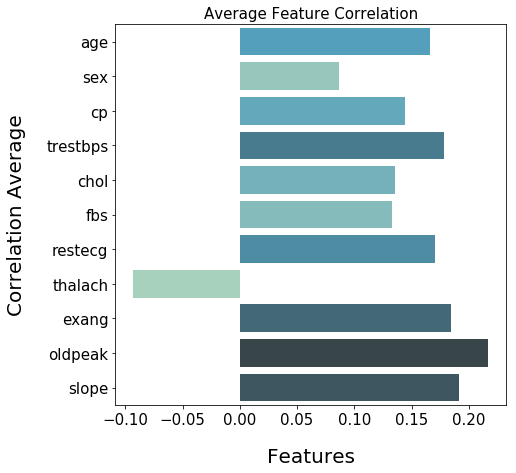

In [13]:
display_rank_graph(feature_names=decoded_heart_disease.columns,
                   metric=corr_feature_means,
                   title="Average Feature Correlation",
                   y_title="Correlation Average",
                   x_title="Features")

<p>&emsp; Oldpeak stands out as having heavy correlation with slope.
    As well as having the most correlation.
    Might be a good idea to drop the feature... </p>

### Plot data

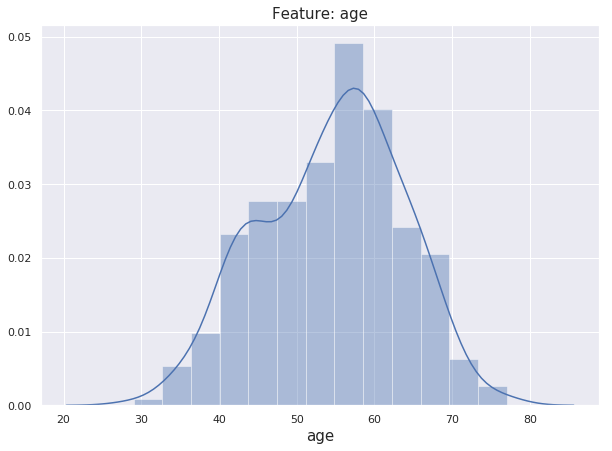

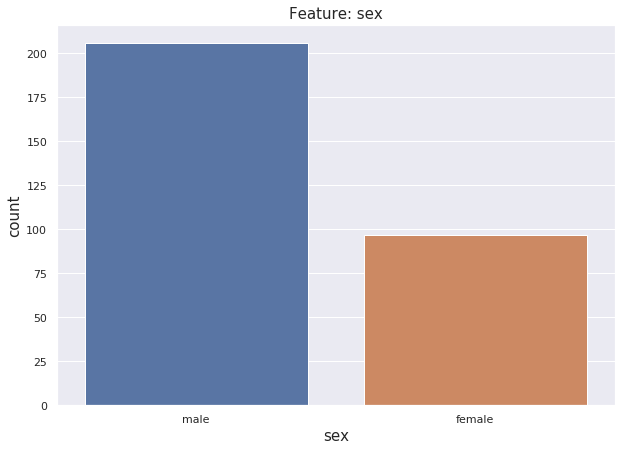

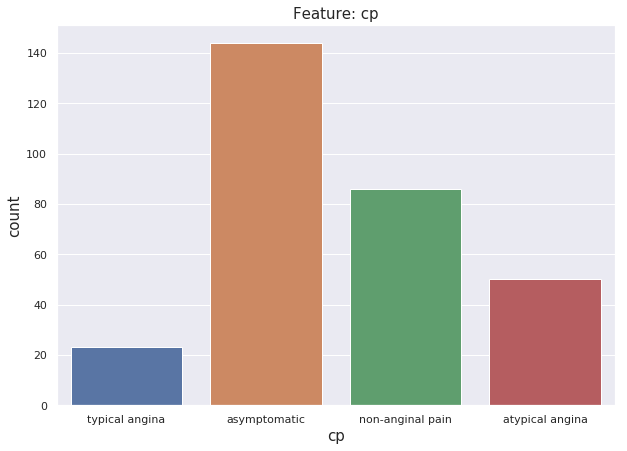

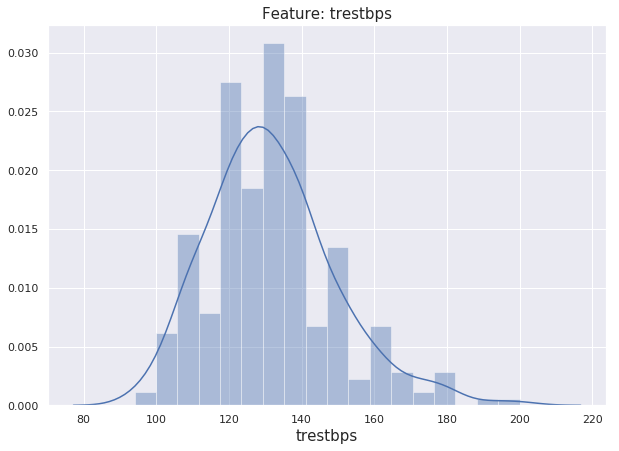

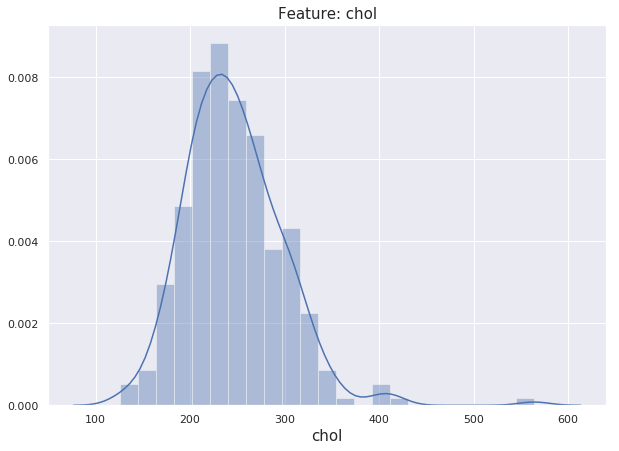

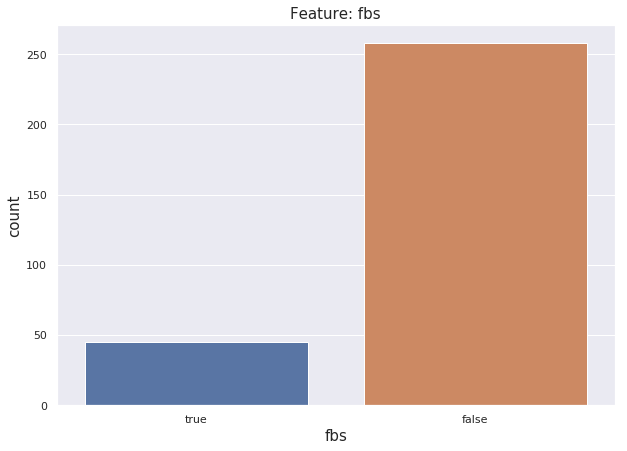

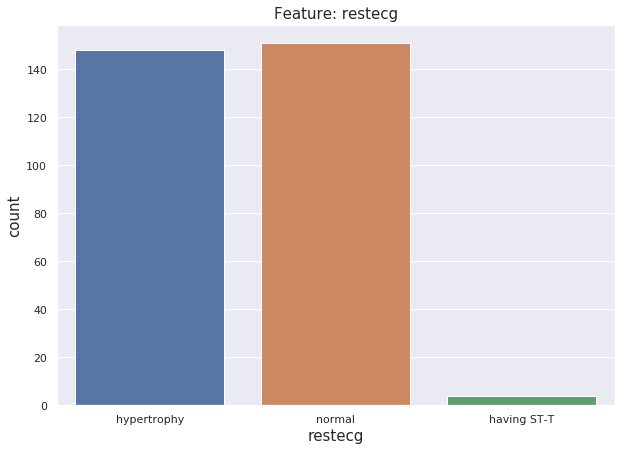

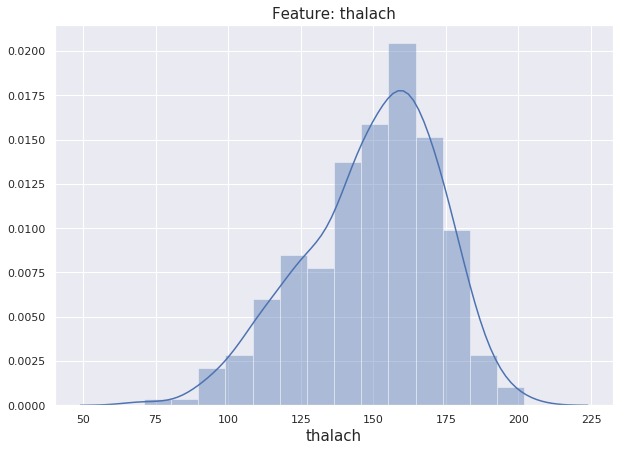

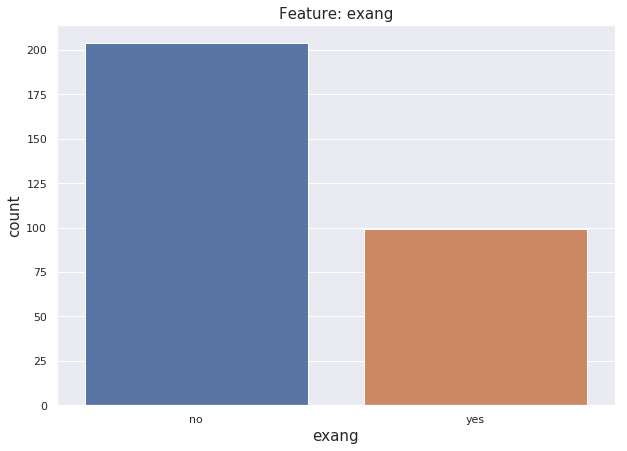

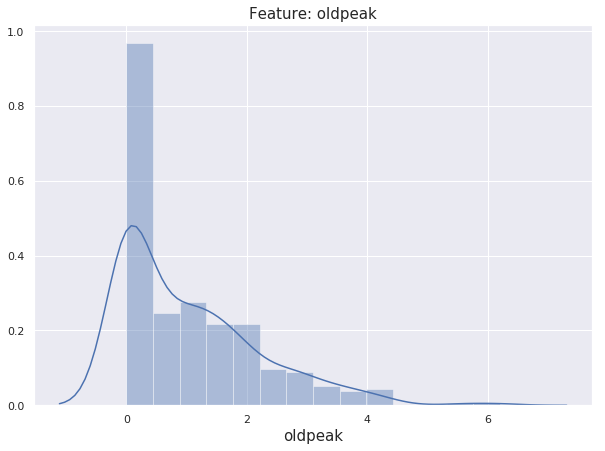

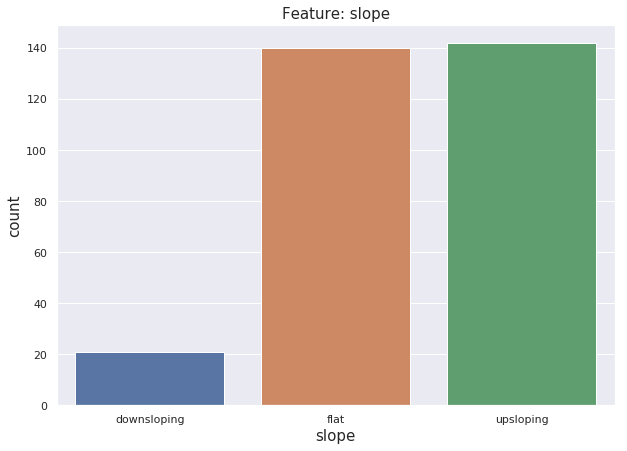

In [14]:
sns.set(style="darkgrid")
sns.set_palette("muted")
sns.set(rc={'figure.figsize': (10, 7)})

for feature_name in decoded_heart_disease.columns:

    plt.title("Feature: " + feature_name,
              fontsize=15)
    if feature_name not in numerical_features:
        plt.ylabel("count", fontsize=15)
        sns.countplot(decoded_heart_disease[feature_name])
    else:
        sns.distplot(decoded_heart_disease[feature_name])

    plt.xlabel(feature_name, fontsize=15)
    plt.show()
    plt.close()
    vertical_spacing(2)

### Quick General Analsysis
<b>age</b>: <p>&emsp; The dataset showed
    slightly skewed distribtuion of ages of people.
    Most common age is between 51 to 60.
    Np.log might help a tiny bit here; and
    the removal of outliers will help.</p>
***
<b>sex</b>: <p>&emsp; Around twice
    as many males as females in this dataset. </p>
***
<b>cp</b>: <p>&emsp; The information showed chest
    pain type was mainly asymptomatic for people. </p>
***
<b>trestbps</b>: <p>&emsp; Seems to be decent
    distribution between the values of 110 to 170.
    Outliers causing a slight problem.
    Graph is appearing more skewed then it should.
    Np.log seems like it would help drastically here.
    Outliers might be able to stay...might.</p>
***
<b>chol</b>: <p>&emsp; Distribution between
    the values of 150 to 350.
    Skewed distribution caused from outliers.
    Np.log required and removal of outliers.</p>
***
<b>fbs</b>: <p>&emsp; More common to find people
    not having fasting blood sugar levels.</p>
***
<b>restecg</b>: <p>&emsp; The data showed people
    having a ST-T was the most rare by a large margin.
    While having a normal and
    hypertrophic had very similar counts. </p>
***
<b>thalach</b>: <p>&emsp; Distribution between the
    values of 100 to 200.
    Slightly skewed data due to outliers.
    But might be the best numeri distr in the df.</p>
***
<b>exang</b>: <p>&emsp; Statistically there were more
    people did <b>not</b> have exercise induced angina.</p>
***
<b>oldpeak</b>: <p>&emsp; Horrid distribution. Np.log
    has no chance of solving this distribution.
    God can't even help this distribution.
    Possible suggestion: delete column. </p>
***
<b>slope</b>: <p>&emsp; The slope of the peak
    exercise ST segment was usually upsloping or flat
    (which they were around the same). Rarely downsloping.</p>
***
<b>Additionally, the following features adhere
    to the documentation encoded
    values by the values being in between
    the specfied range.</b>

### Attempt to center out numerical data

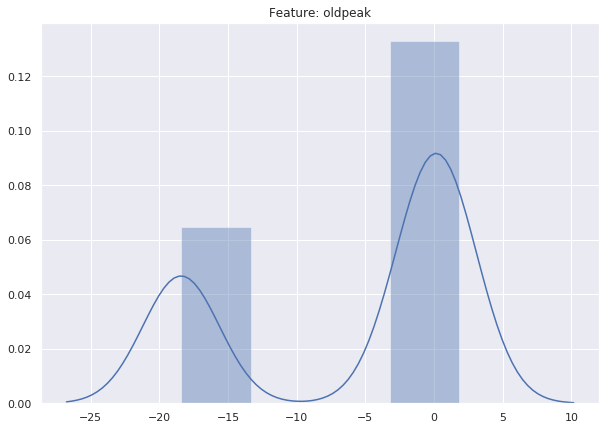

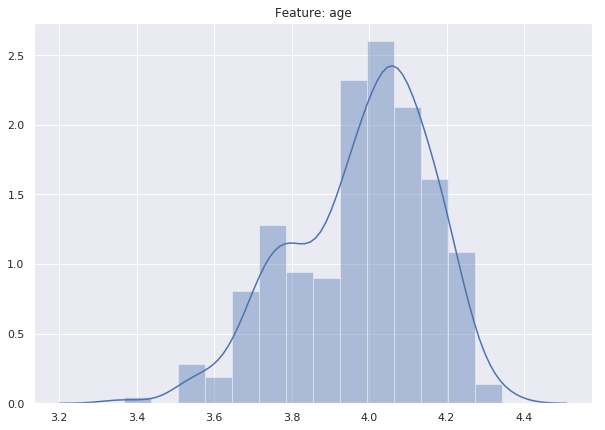

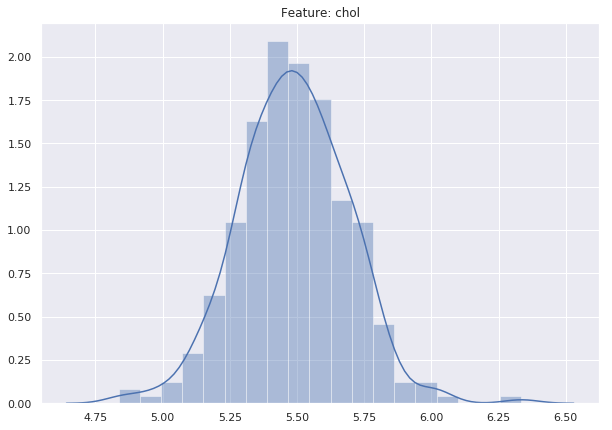

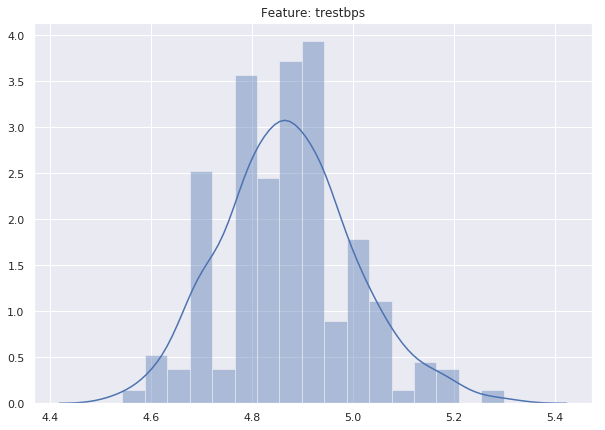

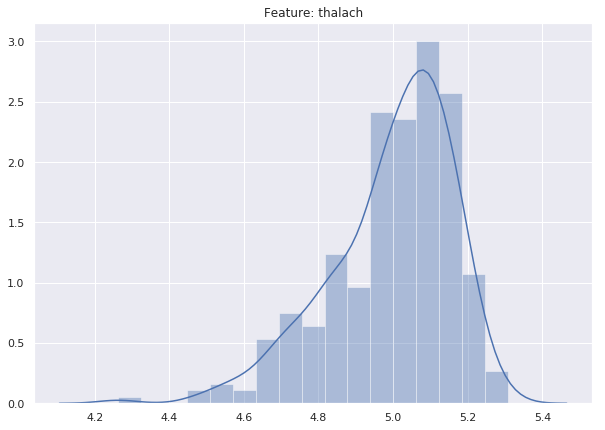

In [15]:
for feature_name in numerical_features:

    positive_only_vector = np.where(decoded_heart_disease[feature_name] < 1e-5,
                                    1e-8, decoded_heart_disease[feature_name])

    plt.title("Feature: " + feature_name)
    sns.distplot(np.log(positive_only_vector))
    plt.show()
    plt.close()

## 4.) Data transformation

<p>Due to heavy correlation, skewed
    distributions, and
    inability to center out with np.log;I
    have decided to remove the f
    eature 'oldpeak'.</p>

### Feature 'oldpeak' and 'slope' removal

In [16]:
decoded_heart_disease.drop('oldpeak', axis=1, inplace=True)
numerical_features.remove("oldpeak")
float_features.remove("oldpeak")

decoded_heart_disease.drop('slope', axis=1, inplace=True)
categorical_features.remove("slope")

### Remove 'having ST-T' from restecg

In [17]:
decoded_heart_disease = decoded_heart_disease[
    decoded_heart_disease["restecg"] != "having ST-T"]
heart_disease = encode_decode_df(passed_df=decoded_heart_disease,
                                 encoder_decoder_map=master_encoder)

In [18]:
heart_disease.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang
0,63,1,1,145,233,1,2,150,0
1,67,1,4,160,286,0,2,108,1
2,67,1,4,120,229,0,2,129,1
3,37,1,3,130,250,0,0,187,0
4,41,0,2,130,204,0,2,172,0


### Removal of numerical outliers

#### Init removal dict with specify removal values

In [19]:
outlier_removal_dict = dict()
outlier_removal_dict["age"] = {"High": None,
                               "Low": 30}
outlier_removal_dict["chol"] = {"High": 410,
                                "Low": None}
outlier_removal_dict["thalach"] = {"High": None,
                                   "Low": 90}
outlier_removal_dict["trestbps"] = {"High": 185,
                                    "Low": None}

#### Peform Removal and re-init dataframes

In [20]:
print("Old dataframe size {0}".format(heart_disease.shape))

Old dataframe size (299, 9)


In [21]:
heart_disease = remove_outliers_df(
    df=heart_disease, removal_dict=outlier_removal_dict)
heart_disease.head()

display(heart_disease.head())
display(heart_disease.shape)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang
0,63,1,1,145,233,1,2,150,0
1,67,1,4,160,286,0,2,108,1
2,67,1,4,120,229,0,2,129,1
3,37,1,3,130,250,0,0,187,0
4,41,0,2,130,204,0,2,172,0


(291, 9)

In [22]:
encoded_heart_disease = heart_disease
decoded_heart_disease = encode_decode_df(passed_df=encoded_heart_disease,
                                         encoder_decoder_map=master_decoder)
display(decoded_heart_disease.head())
display(decoded_heart_disease.shape)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang
0,63,male,typical angina,145,233,true,hypertrophy,150,no
1,67,male,asymptomatic,160,286,false,hypertrophy,108,yes
2,67,male,asymptomatic,120,229,false,hypertrophy,129,yes
3,37,male,non-anginal pain,130,250,false,normal,187,no
4,41,female,atypical angina,130,204,false,hypertrophy,172,no


(291, 9)

#### Np.Log the following the features internally in the dataset

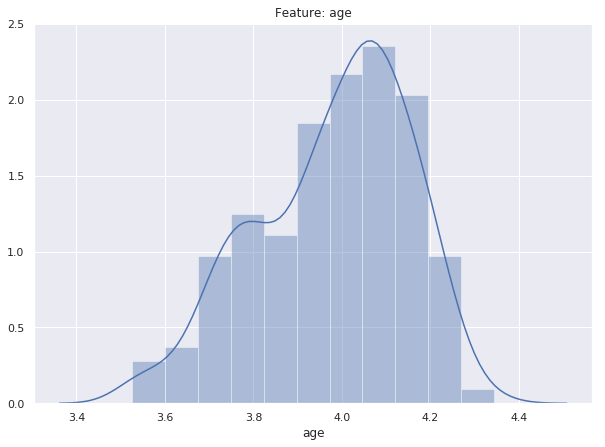

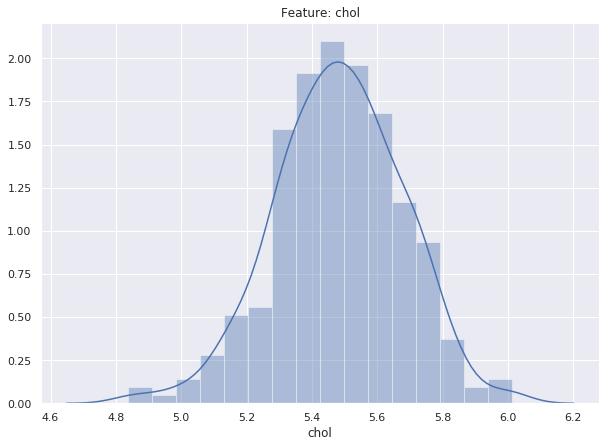

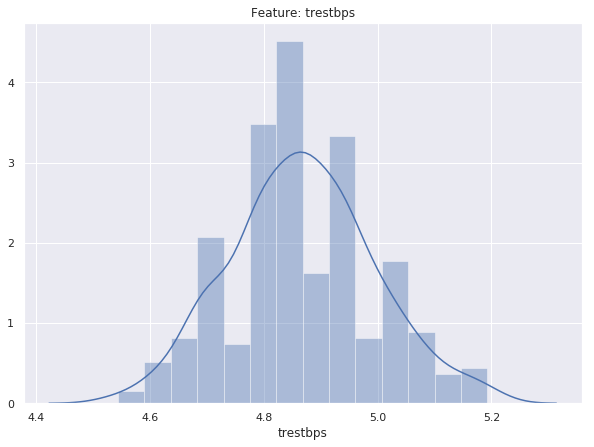

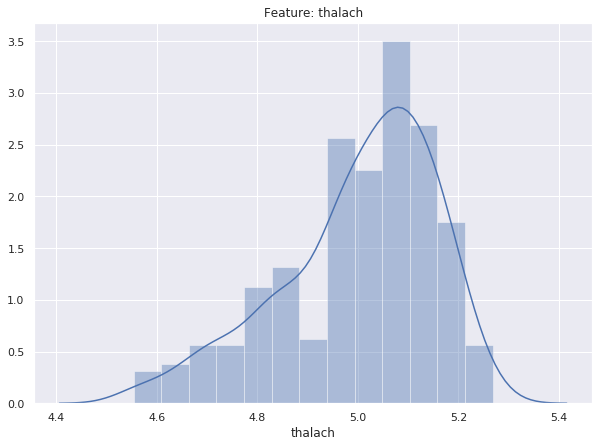

In [23]:
for feature_name in numerical_features:

    heart_disease[feature_name] = np.log(
        np.where(heart_disease[feature_name] < 1e-5,
                 1e-8, heart_disease[feature_name]))

    plt.title("Feature: " + feature_name)
    sns.distplot(heart_disease[feature_name])
    plt.show()
    plt.close()

#### One hot encode dataframe

In [24]:
heart_disease = pd.get_dummies(heart_disease,
                               columns=list(categorical_features),
                               prefix=list(categorical_features))
heart_disease.head()

,age,trestbps,chol,thalach,restecg_0,restecg_2,exang_0,exang_1,fbs_0,fbs_1,sex_0,sex_1,cp_1,cp_2,cp_3,cp_4
0,4.143135,4.976734,5.451038,5.010635,0,1,1,0,0,1,0,1,1,0,0,0
1,4.204693,5.075174,5.655992,4.682131,0,1,0,1,1,0,0,1,0,0,0,1
2,4.204693,4.787492,5.433722,4.859812,0,1,0,1,1,0,0,1,0,0,0,1
3,3.610918,4.867534,5.521461,5.231109,1,0,1,0,1,0,0,1,0,0,1,0
4,3.713572,4.867534,5.318120,5.147494,0,1,1,0,1,0,1,0,0,1,0,0


### Scale current data and inspect scaled data

In [25]:
scaler = StandardScaler()
scaled = scaler.fit_transform(heart_disease)

/home/eric/anaconda3/envs/Data_Sci/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/eric/anaconda3/envs/Data_Sci/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [26]:
inspect_feature_matrix(matrix=scaled,
                       feature_names=heart_disease.columns)

,Mean,Standard Dev
age,-4.593500e-16,1.0
trestbps,-2.548553e-15,1.0
chol,-4.852934e-16,1.0
thalach,-2.746944e-16,1.0
restecg_0,1.465037e-16,1.0
restecg_2,-9.766910e-17,1.0
exang_0,-7.477791e-17,1.0
exang_1,2.136512e-17,1.0
fbs_0,5.188671e-17,1.0
fbs_1,4.120415e-17,1.0


In [27]:
scaled

array([[ 9.54402018e-01,  8.70641599e-01, -1.58993358e-01, ...,
        -4.44444444e-01, -6.31694912e-01, -9.43191598e-01],
       [ 1.31472551e+00,  1.65480342e+00,  8.93532621e-01, ...,
        -4.44444444e-01, -6.31694912e-01,  1.06022997e+00],
       [ 1.31472551e+00, -6.36837496e-01, -2.47920974e-01, ...,
        -4.44444444e-01, -6.31694912e-01,  1.06022997e+00],
       ...,
       [ 3.68572648e-01,  7.73122968e-04, -3.11619180e+00, ...,
        -4.44444444e-01, -6.31694912e-01,  1.06022997e+00],
       [ 3.68572648e-01,  7.73122968e-04, -9.32938499e-02, ...,
         2.25000000e+00, -6.31694912e-01, -9.43191598e-01],
       [-2.00478027e+00,  4.76489391e-01, -1.62902623e+00, ...,
        -4.44444444e-01,  1.58304267e+00, -9.43191598e-01]])

#### Apply PCA to scaled matrix and inspect scaled data

In [28]:
# Create PCA instance: model
pca_model = PCA(random_state=9814)

# Apply the fit_transform method of model to scaled
scaled = pca_model.fit_transform(scaled)

In [29]:
inspect_feature_matrix(matrix=scaled,
                       feature_names=heart_disease.columns)

,Mean,Standard Dev
age,1.831296e-17,1.804731e+00
trestbps,-1.098777e-16,1.497714e+00
chol,-2.441728e-17,1.462155e+00
thalach,-7.325183e-17,1.338144e+00
restecg_0,-3.662591e-17,1.135466e+00
restecg_2,-3.052160e-17,1.108496e+00
exang_0,-4.730847e-17,9.996054e-01
exang_1,-4.273023e-17,9.731022e-01
fbs_0,2.441728e-17,9.381532e-01
fbs_1,1.983904e-17,8.655348e-01


In [30]:
scaled

array([[ 3.85059041e-01,  4.16285421e+00,  2.13388945e+00, ...,
         1.12451414e-15,  6.04937820e-17, -1.81197432e-16],
       [ 3.78754750e+00,  1.99020492e-01, -8.28128314e-01, ...,
         4.56714794e-16, -1.24518341e-16, -5.10649338e-16],
       [ 3.11833387e+00, -5.45475863e-01, -2.96398453e-01, ...,
         1.09052566e-15, -2.49931248e-16,  1.33973676e-16],
       ...,
       [ 2.02958628e+00, -2.40681037e+00,  1.30576108e+00, ...,
         1.68541026e-16, -6.21130128e-17,  8.05388079e-17],
       [-1.68494290e+00,  8.78816986e-01, -2.20918600e+00, ...,
        -1.66825658e-16,  9.83045271e-17,  9.73639355e-17],
       [-2.32485267e+00, -1.15852709e+00,  1.79742137e+00, ...,
         4.47407000e-18, -5.77627285e-17, -9.80904100e-17]])

#### Re-apply scaler after PCA applied

In [31]:
scaled = scaler.fit_transform(scaled)
inspect_feature_matrix(matrix=scaled,
                       feature_names=heart_disease.columns)

,Mean,Standard Dev
age,-3.052160e-18,1.0
trestbps,-6.104319e-18,1.0
chol,-6.104319e-18,1.0
thalach,-1.220864e-17,1.0
restecg_0,-1.220864e-17,1.0
restecg_2,0.000000e+00,1.0
exang_0,-1.373472e-17,1.0
exang_1,0.000000e+00,1.0
fbs_0,3.052160e-18,1.0
fbs_1,1.373472e-17,1.0


In [32]:
scaled

array([[ 0.2133609 ,  2.77947182,  1.45941379, ...,  2.98934937,
         0.15072169, -0.79552392],
       [ 2.09867702,  0.13288283, -0.56637511, ...,  1.16853894,
        -0.53811017, -2.40389343],
       [ 1.72786628, -0.36420559, -0.2027134 , ...,  2.89667693,
        -1.00504392,  0.74312738],
       ...,
       [ 1.12459212, -1.60698917,  0.89303863, ...,  0.38280921,
        -0.30576443,  0.48226073],
       [-0.9336255 ,  0.58677218, -1.51091074, ..., -0.53159592,
         0.29149757,  0.56440025],
       [-1.28819899, -0.77353019,  1.22929589, ..., -0.06453298,
        -0.28956758, -0.38979914]])

## 5.) Start clustering!!!

### K-Means modeling

#### Store models for dynamic usage for the future.

In [33]:
kmeans_models = dict()

#### Generate specified KMeans model

In [34]:
k = 5
first_clust = KMeans(n_clusters=k, random_state=10).fit(scaled)
kmeans_models["kmeans_cluster_5"] = first_clust

### Find the best k value for KMeans

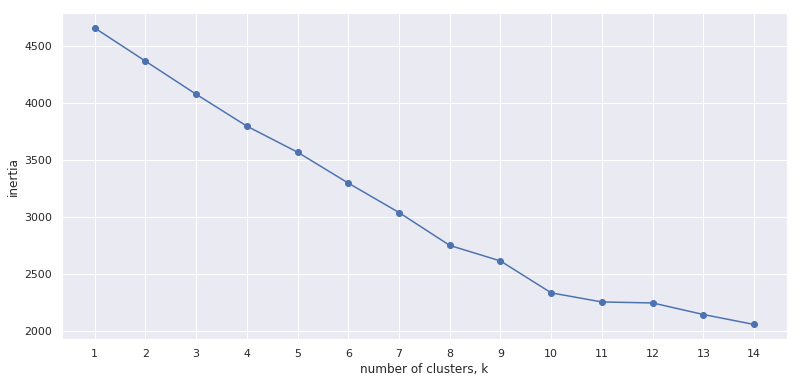

In [35]:
ks = range(1, 15)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k,
                   random_state=10).fit(scaled)

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

# Plot ks vs inertias
plt.figure(figsize=(13, 6))
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()
plt.close()

#### "Elbow" k value looks to be about 8.

In [36]:
kmeans_models["kmeans_cluster_8"] = KMeans(n_clusters=8,
                                           random_state=10).fit(scaled)

## Peform Hierarchical clustering to confirm 'k' value

### Graph cluster to confirm proper k values

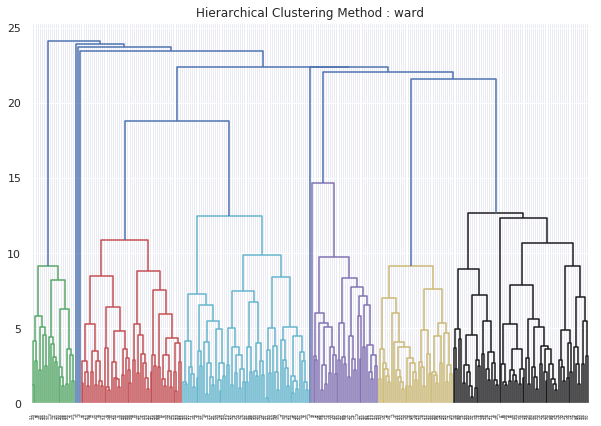

In [37]:
# dendrogram_methods = ["complete",
#                       "single",
#                       "weighted",
#                       "ward",
#                       "average",
#                       "centroid",
#                       "median"]
best_found_methods = ["ward"]

for method in best_found_methods:
    # Calculate the linkage: mergings
    mergings = linkage(scaled, method=method)

    # Plot the dendrogram, using varieties as labels
    dendrogram(mergings,
               labels=list(range(0, len(scaled))),
               leaf_rotation=90,
               leaf_font_size=3,
               )
    plt.title("Hierarchical Clustering Method : " + method)
    plt.show()
    plt.close()

<p>Hierarchical Clustering Method
    shows that there should be between 6-7 clusters.</p>

In [38]:
kmeans_models["kmeans_cluster_7"] = KMeans(n_clusters=8,
                                           random_state=10).fit(scaled)

### Compare models on cluster counts and visualization

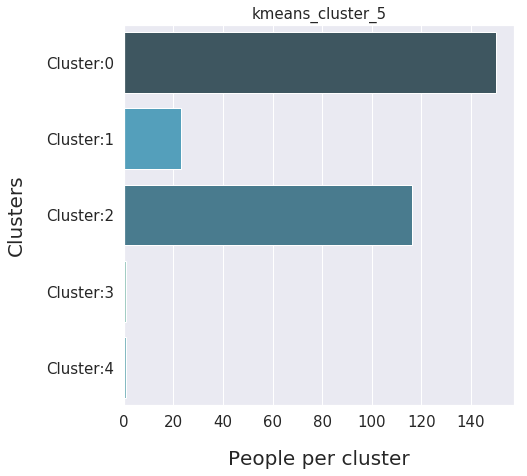

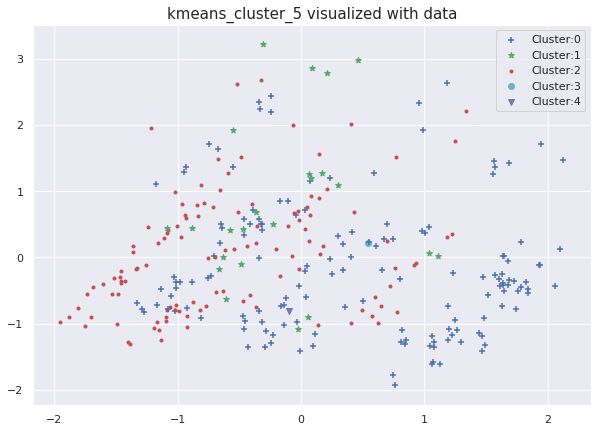

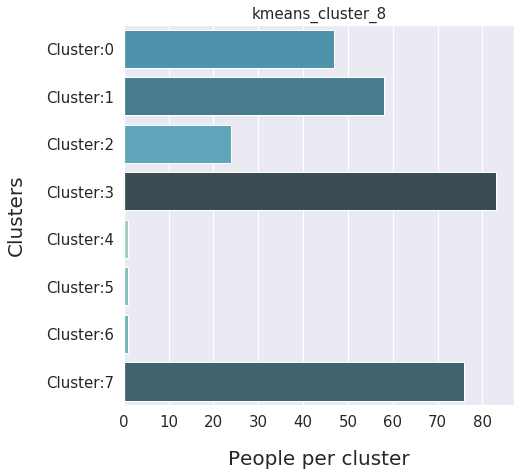

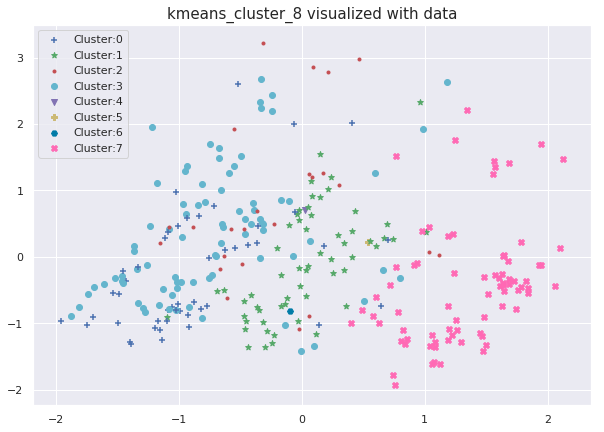

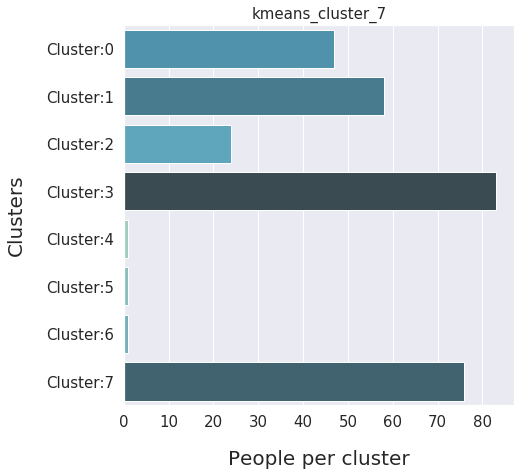

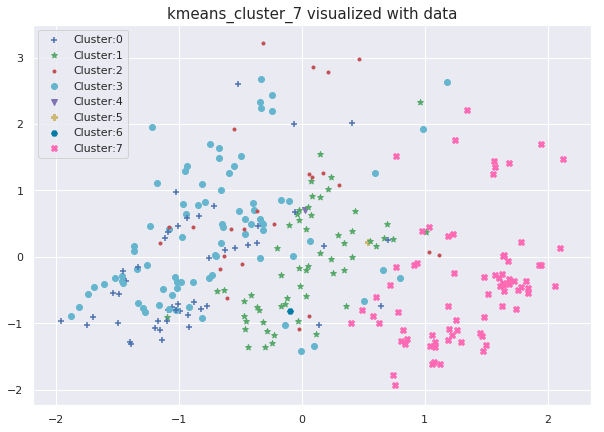

In [39]:
markers = ["+", "*", ".", "o", "v", "P", "H", "X"]
colors = ['b', 'g', 'r', 'c', 'm', 'y', '#007BA7', '#ff69b4']
for model_name, kmeans_model in kmeans_models.items():

    # Display ranking on color based on amount data points per cluster
    unique, counts = np.unique(kmeans_model.labels_, return_counts=True)
    cluster_names = ["Cluster:" + str(cluster_label)
                     for cluster_label in unique]
    display_rank_graph(feature_names=cluster_names,
                       metric=counts,
                       title=model_name,
                       y_title="Clusters",
                       x_title="People per cluster")
    vertical_spacing(2)

    # Display clustered graph
    cluster_array = list(range(0, len(cluster_names)))
    scaled_cluster_label = np.hstack(
        (scaled, np.reshape(
            kmeans_model.labels_.astype(int), (scaled.shape[0], 1))))
    for i in range(0, scaled_cluster_label.shape[0]):
        cluster_label = int(scaled_cluster_label[i][-1])
        cluster_array[cluster_label] = pl.scatter(
            scaled_cluster_label[i, 0], scaled_cluster_label[i, 1],
            c=colors[cluster_label], marker=str(markers[cluster_label]))

    pl.legend(cluster_array, cluster_names)
    pl.title(model_name + ' visualized with data', fontsize=15)
    pl.show()
    pl.close()
    plt.close()

    # Spacing for next model
    vertical_spacing(5)

<p>Our count plots shows k=7
    for kmeans to have the best
    of the given distributions.
    But <b>ALL</b> of our
    models show the data as not
    being very clusterable with kmeans.</p>

## 6.) Create clustering profiles for best model

### Select "best" model to create profiles for each cluster

#### Generate clustered dataframes

In [40]:
best_model_name = "kmeans_cluster_8"

In [41]:
# Re-init dataframes with labels
decoded_heart_disease["Cluster_Name"] = kmeans_models[best_model_name].labels_
encoded_heart_disease = encode_decode_df(passed_df=decoded_heart_disease,
                                         encoder_decoder_map=master_encoder)

# Dataframe to analyze model 'better' choices
model_choices_df = encoded_heart_disease.drop(
    'Cluster_Name', axis=1).drop(encoded_heart_disease.index)

# Store each sub-dataframe based on cluster label
clustered_dataframes = dict()

for cluster_label in set(kmeans_models[best_model_name].labels_):
    cluster_df = encoded_heart_disease[
        encoded_heart_disease["Cluster_Name"] ==
        cluster_label]

    # Ignore cluster with only one patient
    if len(cluster_df) <= 1:
        continue
    # ---
    zscore_cluster_df = cluster_df.drop(
        'Cluster_Name', axis=1).apply(zscore)

    # Check if cluster is only comprised of one data point
    if cluster_df.shape[0] > 1:

        # Iterate through all numerical features
        for numerical_feature in numerical_features:

            # Check for nans
            if not zscore_cluster_df[numerical_feature].isnull().values.any():
                zscore_cluster_df = zscore_cluster_df[
                    zscore_cluster_df[numerical_feature] >= -2]
                zscore_cluster_df = zscore_cluster_df[
                    zscore_cluster_df[numerical_feature] <= 2]

    # Dummy list of -1s alloc at given pos of 'zscore_cluster_df' indexs
    reshaped_index = [-1] * len(encoded_heart_disease.index.values)

    for given_index in list(zscore_cluster_df.index.values):
        reshaped_index[given_index] = given_index

    # Pass back all vectors that passed the zscore test
    bool_array = pd.Series(reshaped_index).astype(int) == pd.Series(
        list(encoded_heart_disease.index.values)).astype(int)

    temp_cluster_df = encoded_heart_disease[bool_array].reset_index(drop=True)

    # Store in proper collection objs
    model_choices_df = model_choices_df.append(temp_cluster_df)

    clustered_dataframes[
        "Cluster:" + str(cluster_label)] = temp_cluster_df.drop(
        'Cluster_Name', axis=1)

/home/eric/anaconda3/envs/Data_Sci/lib/python3.6/site-packages/scipy/stats/stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/eric/anaconda3/envs/Data_Sci/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [42]:
cluster_profiles_df = pd.DataFrame(columns=encoded_heart_disease.columns).drop(
    'Cluster_Name', axis=1)
rows_count = 0
for cluster_identfier, cluster_dataframe in clustered_dataframes.items():
    df = pd.DataFrame(columns=cluster_dataframe.columns)
    df = df.append(cluster_dataframe.mean(), ignore_index=True)
    df.index = [cluster_identfier]

    # Attempt to convert numbers found within the full set of data
    for col in cluster_dataframe.columns:
        if col not in float_features:
            df[col] = find_nearest(numbers=encoded_heart_disease[
                col].value_counts().index.tolist(),
                                   target=df[col].values[0])

    # Evaluate cluster dataframe by dataframe
    eval_df = pd.DataFrame(columns=cluster_dataframe.columns)
    eval_df = eval_df.append(cluster_dataframe.mean(), ignore_index=True)
    eval_df = eval_df.append(cluster_dataframe.min(), ignore_index=True)
    eval_df = eval_df.append(cluster_dataframe.median(), ignore_index=True)
    eval_df = eval_df.append(cluster_dataframe.max(), ignore_index=True)
    eval_df = eval_df.append(cluster_dataframe.std(), ignore_index=True)
    eval_df = eval_df.append(cluster_dataframe.var(), ignore_index=True)
    eval_df.index = ["Mean", "Min", "Median",
                     "Max", "Standard Deviation", "Variance"]

    print("Total found in {0} is {1}".format(
        cluster_identfier, cluster_dataframe.shape[0]))
    display(df)
    display(eval_df)

    cluster_profiles_df = cluster_profiles_df.append(
        encode_decode_df(passed_df=df,
                         encoder_decoder_map=master_decoder))
    vertical_spacing(7)

    rows_count += cluster_dataframe.shape[0]
# End clusters loop

print("Total points in all shrunken clusters: ", rows_count)
print("Removed {0} points to get more concise: ".format(
    heart_disease.shape[0] - rows_count))

Total found in Cluster:0 is 38


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang
Cluster:0,50,1,2,124,244,0,0,163,0


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang
Mean,50.368421,0.657895,2.0,124.421053,243.789474,0.131579,0.631579,163.131579,0.052632
Min,35.000000,0.000000,2.0,101.000000,160.000000,0.000000,0.000000,132.000000,0.000000
Median,51.000000,1.000000,2.0,127.000000,236.000000,0.000000,0.000000,163.000000,0.000000
Max,63.000000,1.000000,2.0,140.000000,325.000000,1.000000,2.000000,188.000000,1.000000
Standard Deviation,6.886811,0.480783,0.0,10.255207,41.273090,0.342570,0.942138,12.978508,0.226294
Variance,47.428165,0.231152,0.0,105.169275,1703.467994,0.117354,0.887624,168.441679,0.051209









Total found in Cluster:1 is 52


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang
Cluster:1,55,1,4,128,242,0,2,152,0


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang
Mean,55.192308,0.673077,4.0,127.461538,241.673077,0.057692,1.076923,152.250000,0.0
Min,39.000000,0.000000,4.0,100.000000,149.000000,0.000000,0.000000,109.000000,0.0
Median,57.500000,1.000000,4.0,125.000000,236.500000,0.000000,2.000000,158.000000,0.0
Max,71.000000,1.000000,4.0,160.000000,330.000000,1.000000,2.000000,186.000000,0.0
Standard Deviation,9.087890,0.473665,0.0,16.392803,41.718817,0.235435,1.006764,19.947849,0.0
Variance,82.589744,0.224359,0.0,268.723982,1740.459653,0.055430,1.013575,397.916667,0.0









Total found in Cluster:2 is 22


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang
Cluster:2,56,1,1,140,239,0,2,158,0


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang
Mean,55.727273,0.818182,1.045455,141.000000,238.636364,0.227273,1.272727,157.772727,0.181818
Min,38.000000,0.000000,1.000000,110.000000,186.000000,0.000000,0.000000,125.000000,0.000000
Median,59.000000,1.000000,1.000000,140.000000,234.000000,0.000000,2.000000,160.500000,0.000000
Max,69.000000,1.000000,2.000000,178.000000,298.000000,1.000000,2.000000,190.000000,1.000000
Standard Deviation,9.396969,0.394771,0.213201,19.444671,33.210075,0.428932,0.984732,19.158317,0.394771
Variance,88.303030,0.155844,0.045455,378.095238,1102.909091,0.183983,0.969697,367.041126,0.155844









Total found in Cluster:3 is 67


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang
Cluster:3,52,1,3,130,239,0,0,158,0


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang
Mean,52.029851,0.656716,3.0,129.910448,238.208955,0.149254,0.865672,158.194030,0.119403
Min,37.000000,0.000000,3.0,100.000000,149.000000,0.000000,0.000000,123.000000,0.000000
Median,51.000000,1.000000,3.0,130.000000,233.000000,0.000000,0.000000,158.000000,0.000000
Max,69.000000,1.000000,3.0,160.000000,321.000000,1.000000,2.000000,187.000000,1.000000
Standard Deviation,8.344786,0.478389,0.0,13.715432,39.384098,0.359028,0.998416,14.443452,0.326709
Variance,69.635459,0.228856,0.0,188.113071,1551.107191,0.128901,0.996834,208.613297,0.106739









Total found in Cluster:7 is 64


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang
Cluster:7,56,1,4,130,249,0,2,134,1


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang
Mean,55.593750,0.843750,4.0,129.593750,249.421875,0.140625,1.187500,133.546875,1.0
Min,40.000000,0.000000,4.0,100.000000,166.000000,0.000000,0.000000,96.000000,1.0
Median,57.000000,1.000000,4.0,130.000000,248.000000,0.000000,2.000000,132.000000,1.0
Max,70.000000,1.000000,4.0,160.000000,354.000000,1.000000,2.000000,173.000000,1.0
Standard Deviation,7.184018,0.365963,0.0,13.543251,48.763050,0.350382,0.990030,18.780207,0.0
Variance,51.610119,0.133929,0.0,183.419643,2377.835069,0.122768,0.980159,352.696181,0.0









Total points in all shrunken clusters:  243
Removed 48 points to get more concise: 


In [43]:
cluster_profiles_df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang
Cluster:0,50,male,atypical angina,124,244,false,normal,163,no
Cluster:1,55,male,asymptomatic,128,242,false,hypertrophy,152,no
Cluster:2,56,male,typical angina,140,239,false,hypertrophy,158,no
Cluster:3,52,male,non-anginal pain,130,239,false,normal,158,no
Cluster:7,56,male,asymptomatic,130,249,false,hypertrophy,134,yes


## 7.) Visualize kmeans cluster choices with decision tree.

In [44]:
model_choices_df.reset_index(drop=True,
                             inplace=True)
display(model_choices_df["Cluster_Name"].value_counts())
display(model_choices_df.shape)

3.0    67
7.0    64
1.0    52
0.0    38
2.0    22
Name: Cluster_Name, dtype: int64

(243, 10)

### Init naming of clusters before label encode fix

In [45]:
cluster_names = ["Cluster:"+ str(int(cluster_label))
                 for cluster_label in set(
                     model_choices_df["Cluster_Name"].values)]

In [46]:
cluster_names

['Cluster:0', 'Cluster:1', 'Cluster:2', 'Cluster:3', 'Cluster:7']

### Fix encoding problem for visualization of the tree

In [47]:
prev = list(set(model_choices_df["Cluster_Name"].values))[0]
replace_dict = dict()
replace_dict["Cluster_Name"] = dict()

for item in list(set(model_choices_df["Cluster_Name"].values)):
    if prev != item - 1 and prev != item:
        replace_dict["Cluster_Name"][item] = prev + 1
        prev = item - 1
    else:
        replace_dict["Cluster_Name"][item] = item
        prev = item

display(set(model_choices_df["Cluster_Name"].values))
model_choices_df = encode_decode_df(model_choices_df,
                                    replace_dict)
display(set(model_choices_df["Cluster_Name"].values))

{0.0, 1.0, 2.0, 3.0, 7.0}

{0.0, 1.0, 2.0, 3.0, 4.0}

### Train test split on model kmeans model choices

In [48]:
X = np.array(model_choices_df.drop('Cluster_Name', axis=1, inplace=False))
y = np.array(model_choices_df['Cluster_Name'])

# Split dataframe into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.35,
                                                    random_state=528)

### Hyperparamters for dt

In [49]:
# Find best parameters for model
param_grid = {
    "max_depth": list(range(1, 5)),
    "min_samples_leaf": list(range(10, 35, 5)),
    "criterion": ["gini", "entropy"],
}

best_param = optimize_model_grid(
    model=DecisionTreeClassifier(),
    X_train=X_train,
    y_train=y_train,
    param_grid=param_grid
)

# Train our decision tree with 'best' parameters
kmeans_tree = DecisionTreeClassifier(**best_param)
kmeans_tree.fit(X_train, y_train)

train_pred = kmeans_tree.predict(X_train)
test_pred = kmeans_tree.predict(X_test)

Tuned Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 10}
Best score on trained data was 0.993631


/home/eric/anaconda3/envs/Data_Sci/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Look at confusion matrix for both train and test

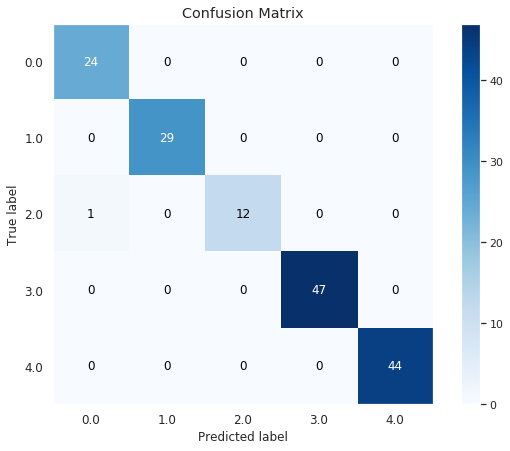

In [50]:
skplt.metrics.plot_confusion_matrix(y_train, train_pred)
plt.show()
plt.close()

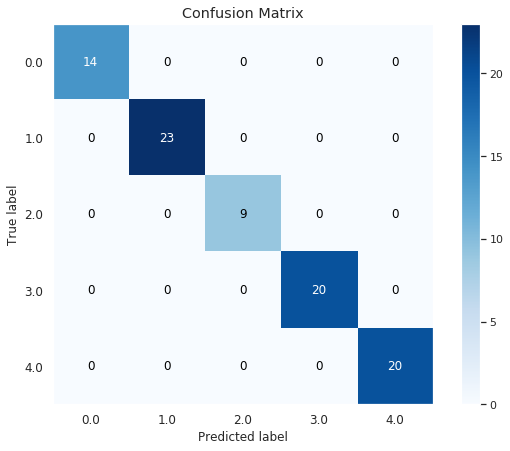

In [51]:
skplt.metrics.plot_confusion_matrix(y_test, test_pred)
plt.show()
plt.close()

### Evaluate Results

In [52]:
tree_stats_test = pd.DataFrame(
    report_to_dict(
        classification_report(y_test,
                              test_pred))).T
display(tree_stats_test)
print("Test accuracy is {0:2f}".format(accuracy_score(y_test, test_pred)))

,f1-score,precision,recall,support
0.0,1.0,1.0,1.0,14.0
1.0,1.0,1.0,1.0,23.0
2.0,1.0,1.0,1.0,9.0
3.0,1.0,1.0,1.0,20.0
4.0,1.0,1.0,1.0,20.0
micro avg,1.0,1.0,1.0,86.0
macro avg,1.0,1.0,1.0,86.0
weighted avg,1.0,1.0,1.0,86.0


Test accuracy is 1.000000


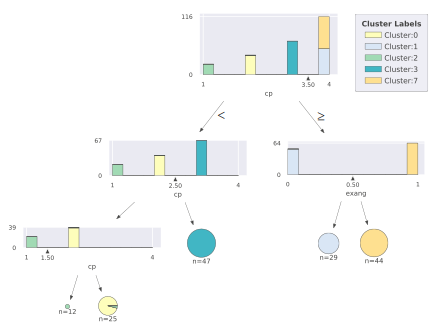

In [64]:
viz = dtreeviz(kmeans_tree, 
               X, 
               y.astype(np.int64),
               target_name='Cluster Labels',
               feature_names=list(model_choices_df.drop(
                   'Cluster_Name', axis=1, inplace=False).columns),
               class_names=cluster_names)  

viz